'Latest multirun: 2025-11-01_16-28-13'

,run,run_dir,loss,trainer.max_epochs,trainer.limit_train_batches,trainer.limit_val_batches,hparams_search,val/loss
0,0,logs/train/multiruns/2025-11-01_16-28-13/0,spatial,3,0.01,0.1,loss_sweep,5.939990
1,1,logs/train/multiruns/2025-11-01_16-28-13/1,clip,3,0.01,0.1,loss_sweep,6.207612


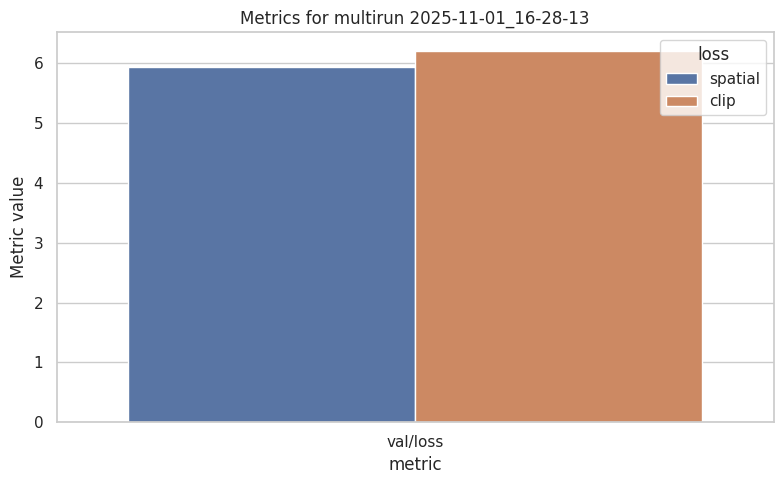

In [2]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml
from IPython.display import display

# Identify the latest multirun folder, aggregate overrides and tracked metrics, then plot them.
LOG_ROOT = Path("logs/train/multiruns")


def get_latest_multirun(root: Path) -> Path:
    runs = [d for d in root.iterdir() if d.is_dir()]
    if not runs:
        raise FileNotFoundError(f"No multirun directories under {root}")
    return max(runs, key=lambda d: d.stat().st_mtime)


def parse_overrides(run_dir: Path) -> dict:
    override_path = run_dir / ".hydra" / "overrides.yaml"
    overrides: dict[str, object] = {}
    if override_path.exists():
        raw_entries = yaml.safe_load(override_path.read_text()) or []
        for raw in raw_entries:
            if isinstance(raw, str) and "=" in raw:
                key, value = raw.split("=", 1)
                try:
                    overrides[key] = yaml.safe_load(value)
                except yaml.YAMLError:
                    overrides[key] = value
    return overrides


_METRIC_RE = re.compile(r"Retrieved metric value!\s*<([^=]+)=([0-9eE+\.\-]+)>")


def parse_metrics(run_dir: Path) -> dict:
    metrics: dict[str, float] = {}
    log_path = run_dir / "train.log"
    if log_path.exists():
        for line in log_path.read_text().splitlines():
            match = _METRIC_RE.search(line)
            if match:
                metrics[match.group(1)] = float(match.group(2))
    return metrics


latest_multirun = get_latest_multirun(LOG_ROOT)
rows: list[dict[str, object]] = []
for subdir in sorted(latest_multirun.iterdir()):
    if not subdir.is_dir() or not subdir.name.isdigit():
        continue
    overrides = parse_overrides(subdir)
    metrics = parse_metrics(subdir)
    if metrics:
        rows.append({"run": int(subdir.name), "run_dir": str(subdir), **overrides, **metrics})

if not rows:
    raise RuntimeError(f"No metrics captured in {latest_multirun}")

df = pd.DataFrame(rows).sort_values("run").reset_index(drop=True)
display(f"Latest multirun: {latest_multirun.name}")
display(df)

metric_cols = [c for c in df.columns if "/" in c]
if metric_cols:
    sns.set_theme(style="whitegrid")
    id_vars = ["run"] + [col for col in ("loss",) if col in df.columns]
    melted = df.melt(id_vars=id_vars, value_vars=metric_cols, var_name="metric", value_name="value")
    hue = "loss" if "loss" in melted.columns else "run"
    plt.figure(figsize=(8, 5))
    sns.barplot(data=melted, x="metric", y="value", hue=hue)
    plt.title(f"Metrics for multirun {latest_multirun.name}")
    plt.ylabel("Metric value")
    plt.tight_layout()
    plt.show()
else:
    print("No slash-delimited metric columns found in the aggregated dataframe.")
